In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model, Input
import matplotlib.pyplot as plt
import muspy
import pypianoroll
import pretty_midi
from keras.utils import  to_categorical
from keras.optimizers import Adam
print ('muspy ver ' , muspy.__version__ )

from numpy import load
import time
import sys
import os
import random

tf.random.set_seed(27)
os.environ['PYTHONHASHSEED'] = str(27)
np.random.seed(27)
random.seed(27)

print("TF ver:",tf.__version__)
#import keras
print("Keras ver:", keras.__version__)

muspy ver  0.5.0
TF ver: 2.17.0
Keras ver: 3.4.1


## Khởi tạo tham số và dữ liệu

In [3]:
MODEL_CONFIG = {
    'num_timestep': 64,
    'num_pitch': 60, # 31, 60

    'num_labels': 4,

    'vae_type': 'vae',  # 'sigma-vae'

    'batch_size': 64,  # 4, 8, 16
    'latent_dim': 32, # 20, 32


    'track_names': (
        'All',
    ),
    # Samples  # number of genarating samples
    'num_sample': 10,

     # Metrics
    'metric_map': np.array([
        # indices of tracks for the metrics to compute
        [True] * 8,  # empty bar rate
        [True] * 8,  # number of pitch used

    ], dtype=bool),

    'scale_mask_Cmajor': list(map(bool, [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1])),
    'scale_mask_Cminor': list(map(bool, [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1])),

    'result_dir': '../content/gen/',
    'run_main_program': False,

    # Directories
    'checkpoint_dir': None,
    'sample_dir': None,
    'eval_dir': None,
    'log_dir': None,
    'src_dir': None,

    'verbose_print_summary': False,
    }

In [4]:
DATA_CONFIG = {
    'training_data': '/content/music_tensor.npz',
}

TRAIN_CONFIG = {
    'num_epoch': 2000,
    'evaluate_after_training': True ,
    'batch_size': 4, 
    'evaluate_along_training': True,
    'save_interval': 10 
}


In [6]:
def shuffle_data(train_X, train_y):
    from sklearn.utils import shuffle
    print ("train_y: \n", train_y)
    train_X, train_y = shuffle(train_X, train_y, random_state=42)
    print ("train_y: \n", train_y)
    unique_elements, counts_elements = np.unique(train_y, return_counts=True)
    print("Frequency of unique values of the said array:")
    print(np.asarray((unique_elements, counts_elements)))

    return train_X, train_y

In [7]:
def load_data_emo():
    print('[*] Loading data...')
    dict_data = np.load(DATA_CONFIG['training_data'])
    # print(dict_data.files)
    train_X = dict_data['arr_0']
    train_y = dict_data['arr_1']

    print("train_X.shape", train_X.shape)
    train_X = np.reshape(train_X, (-1, MODEL_CONFIG['num_timestep'], MODEL_CONFIG['num_pitch'], 1))

    print("train_X.shape", train_X.shape)
    print("train_y.shape", train_y.shape)
    train_X, train_y = shuffle_data(train_X, train_y)

    return train_X, train_y

In [8]:
def labels_to_categorical(train_y):
    train_y_onehot = to_categorical(train_y)

    print("train_y_onehot.shape: ", train_y_onehot.shape)
    print("train_y_onehot[0]: ", train_y_onehot[0])
    return train_y_onehot

In [9]:
DATA_CONFIG['training_data'] = SETUP['training_data']
train_X, train_y =  load_data_emo()
train_y_onehot = labels_to_categorical(train_y)

[*] Loading data...
train_X.shape (1044, 64, 60)
train_X.shape (1044, 64, 60, 1)
train_y.shape (1044,)
train_y: 
 [0 0 0 ... 3 3 3]
train_y: 
 [3 1 2 ... 1 0 3]
Frequency of unique values of the said array:
[[  0   1   2   3]
 [214 308 306 216]]
train_y_onehot.shape:  (1044, 4)
train_y_onehot[0]:  [0. 0. 0. 1.]


In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
print(train_X.shape)

(1044, 64, 60, 1)


In [ ]:
print("num_pitch: ", MODEL_CONFIG['num_pitch'])
# TRAIN_CONFIG['num_epoch']
print("num_epoch: ", TRAIN_CONFIG['num_epoch'])

num_pitch:  60
num_epoch:  1000


## Trực quan hóa dữ liệu đầu vào

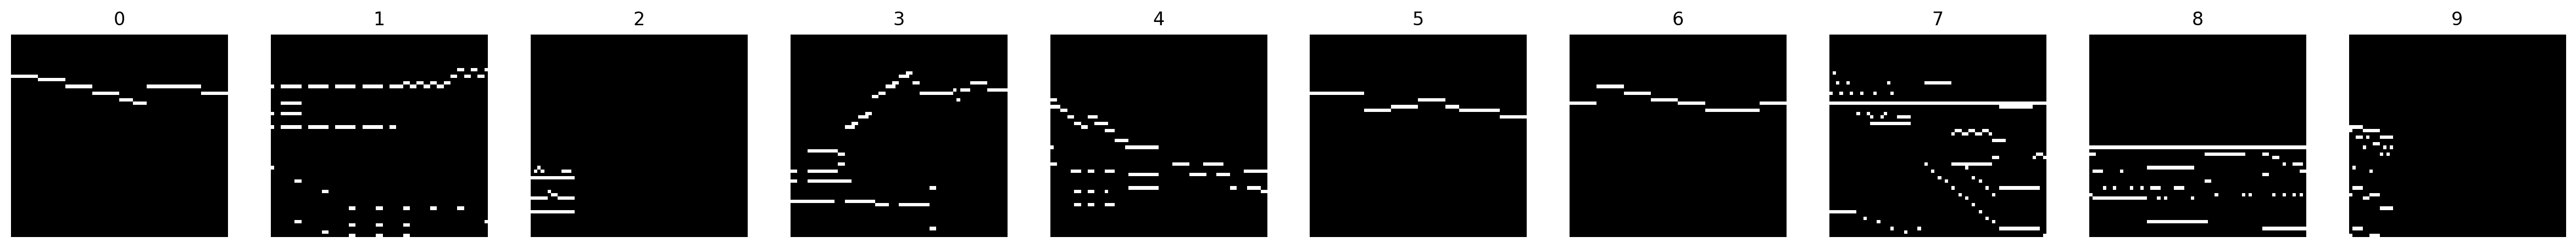

(1044, 64, 60, 1)

In [10]:
def plotMulRep(piano_representations, start):
    fig = plt.figure(figsize=(30,10))

    axs = fig.subplots(1, 10)

    for i in range(10):
        axs[i].axis('off')
        new_my_pianoroll_rep1 =  np.rot90 (piano_representations[i+ start])
        axs[i].imshow(new_my_pianoroll_rep1, cmap='gray')
        axs[i].set_title(str(i+ start))
    plt.show()

for i in range (1) :
    plotMulRep(train_X, 10 * i)
train_X.shape

### Trực quan hóa 1 đầu vào

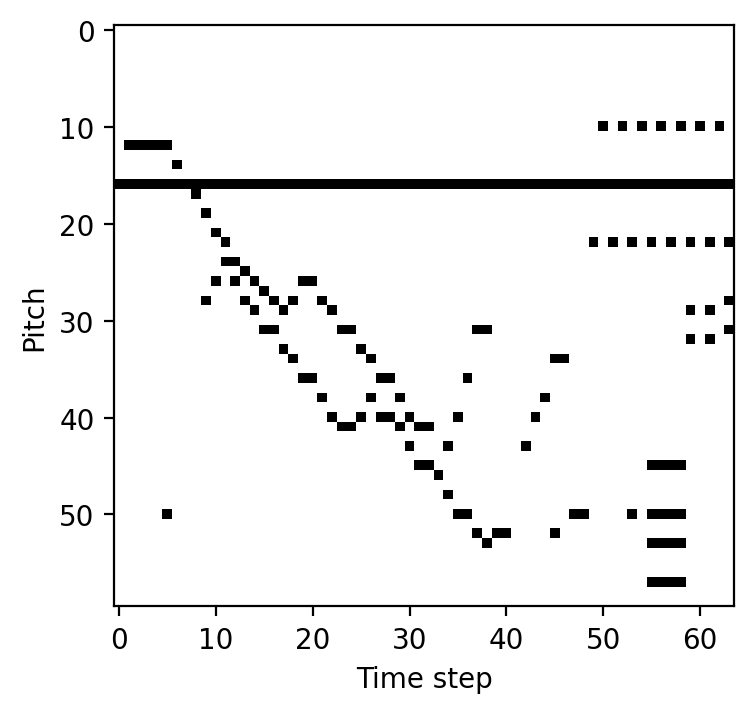

In [27]:
import matplotlib.pyplot as plt
def plotRep(piano_represent_in):
    fig = plt.figure(figsize=(4,4))

    axs = fig.subplots(1, 1)

    new_my_pianoroll_rep1 =  np.rot90 (piano_represent_in)
    new_my_pianoroll_rep1 = 1 - new_my_pianoroll_rep1
    axs.imshow(new_my_pianoroll_rep1, cmap='gray')
    axs.set_xlabel('Time step')
    axs.set_ylabel('Pitch')
    plt.show()

plotRep(train_X[432])
# plotRep(train_X[3])   
# plotRep(train_X[4])  

## VAE training

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super(Sampling, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
def encoder(latent_dim=MODEL_CONFIG['latent_dim'], num_emotions=MODEL_CONFIG['num_labels']):
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    input_shape = (MODEL_CONFIG['num_timestep'], MODEL_CONFIG['num_pitch'], 1)
    music_input = Input(shape=input_shape, name="music_input")
    emotion_input = Input(shape=(num_emotions,), name="emotion_input")

    emotion_dense = layers.Dense(input_shape[0] * input_shape[1])(emotion_input)
    emotion_expanded = layers.Reshape(input_shape)(emotion_dense)

    combined_input = layers.Concatenate()([music_input, emotion_expanded])

    x = combined_input
    layer1_units = 64
    layer2_units = 128

    p1 = layers.Conv2D(layer1_units, kernel_size=(1, 12), strides=(1, 12))(x)
    p1 = layers.LeakyReLU()(p1)
    p1 = layers.Conv2D(layer2_units, kernel_size=(4, 1), strides=(4, 1))(p1)
    p1 = layers.LeakyReLU()(p1)

    p2 = layers.Conv2D(layer1_units, kernel_size=(4, 1), strides=(4, 1))(x)
    p2 = layers.LeakyReLU()(p2)
    p2 = layers.Conv2D(layer2_units, kernel_size=(1, 12), strides=(1, 12))(p2)
    p2 = layers.LeakyReLU()(p2)

    x = layers.Concatenate(axis=3)([p1, p2])

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    return Model([music_input, emotion_input], [z_mean, z_log_var, z], name="encoder")

# Decoder
def decoder(latent_dim=MODEL_CONFIG['latent_dim'], input_shape=(64, 60, 1), num_emotions=MODEL_CONFIG['num_labels']):
    latent_input = Input(shape=(latent_dim,), name="latent_input")
    emotion_input = Input(shape=(num_emotions,), name="emotion_input")

    x = layers.Concatenate()([latent_input, emotion_input])

    x = layers.Dense(16 * 5 * 128)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Reshape((16, 5, 128))(x)
    layer1_units = 64
    layer2_units = 128

    p1 = layers.Conv2DTranspose(layer2_units, kernel_size=(1, 12), strides=(1, 12))(x)
    # p1 = layers.BatchNormalization()(p1)
    p1 = layers.ReLU()(p1)
    p1 = layers.Conv2DTranspose(layer1_units, kernel_size=(4, 1), strides=(4, 1))(p1)
    # p1 = layers.BatchNormalization()(p1)
    p1 = layers.ReLU()(p1)

    p2 = layers.Conv2DTranspose(layer2_units, kernel_size=(4, 1), strides=(4, 1))(x)
    # p2 = layers.BatchNormalization()(p2)
    p2 = layers.ReLU()(p2)
    p2 = layers.Conv2DTranspose(layer1_units, kernel_size=(1, 12), strides=(1, 12))(p2)
    # p2 = layers.BatchNormalization()(p2)
    p2 = layers.ReLU()(p2)

    x = layers.Concatenate(axis=3)([p1, p2])
    decoder_outputs = layers.Conv2DTranspose(1, kernel_size=(1, 1), strides=(1, 1), activation="sigmoid", padding="same")(x)

    return Model([latent_input, emotion_input], decoder_outputs, name="decoder")

In [ ]:
# Plot and Generate Labels Functions
def plotRepCVAE(piano_representations, epoch, config, name):
    fig = plt.figure(figsize=(30, 20))
    num_samples = piano_representations.shape[0]
    axs = fig.subplots(1, num_samples)
    for i in range(num_samples):
        axs[i].axis('off')
        new_my_pianoroll_rep1 = np.rot90(piano_representations[i])
        axs[i].imshow(new_my_pianoroll_rep1, cmap='gray')
        axs[i].set_title(str(i))
    filename1 = f'Samples_{num_samples}_images_{epoch + 1}_{name}.png'
    plt.savefig(filename1)
    plt.close()

def generate_labels(num_sample):
    cond_num = np.zeros((num_sample, 1))
    for i in range(num_sample):
        ind = (i % 4)
        cond_num[i] = ind
    condition_emo = to_categorical(cond_num, 4)
    return condition_emo

def back_to_pianoroll(samples):
    print("samples: ", samples.shape)

    samples_piano_representations_arr = np.reshape (samples, (samples.shape[0], samples.shape[1], samples.shape[2] ) )
    samples_p_rep = samples_piano_representations_arr
    samples_pianoroll_rep =  np.pad(samples_p_rep, ( (0, 0), (0, 0), (25, 43)) , 'constant', constant_values=( 0, 0))
    print("samples_pianoroll_rep.shape: ", samples_pianoroll_rep.shape)
    return samples_pianoroll_rep

def save_midi_samples(samples_pianoroll, epoch, config):
    for i in range(samples_pianoroll.shape[0]):
        my_music = muspy.from_pianoroll_representation (samples_pianoroll[i], resolution=4, encode_velocity=False)

        filename1 = 'MIDI_epoch_%04d_%s.mid' % (epoch+1, i)
        path = os.path.join(config['result_dir'], filename1)
        muspy.write_midi(path , my_music)
        print('MIDI saved to %s' % path)

In [ ]:
# CVAE Class
class CVAE(Model):
    def __init__(self, encoder, decoder, initial_beta_kl=0.1, final_beta_kl=1.0):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta_kl = initial_beta_kl
        self.final_beta_kl = final_beta_kl

    def train_step(self, data):
        music_input, emotion_input = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([music_input, emotion_input])
            reconstruction = self.decoder([z, emotion_input])

            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(music_input, reconstruction), axis=(1, 2)
                    # tf.keras.losses.mean_squared_error(music_input, reconstruction)
                )
            )
            # KL Divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + self.beta_kl * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        music_input, emotion_input = inputs
        z_mean, z_log_var, z = self.encoder([music_input, emotion_input])
        reconstruction = self.decoder([z, emotion_input])
        return reconstruction

    def run_sampler(self, epoch, config):
        num_sample = config['num_sample']
        latent_dim = config['latent_dim']
        z_sample = tf.random.normal(shape=(num_sample, latent_dim))
        print("z_sample.shape: ", z_sample.shape)

        condition_emo = generate_labels(num_sample)
        print("condition_emo[0]: ", condition_emo[0])
        x_decoded = self.decoder.predict([z_sample, condition_emo])
        x_decoded_round = x_decoded > 0.5

        print("x_decoded.shape: ", x_decoded.shape)

        plotRepCVAE(x_decoded_round, epoch, config, name='vae_rounded')
        return x_decoded_round

In [ ]:
# Compile and Train CVAE
latent_dim = MODEL_CONFIG['latent_dim']
encoder_model = encoder(latent_dim=latent_dim)
decoder_model = decoder(latent_dim=latent_dim)

# Define the initial learning rate
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

cvae = CVAE(encoder_model, decoder_model, initial_beta_kl=0.1, final_beta_kl=1.0)
cvae.compile(optimizer)

# Summarize the architecture
cvae.encoder.summary()
cvae.decoder.summary()

loss_all, reconstruction_loss_all, kl_loss_all = [], [], []

num_epochs = TRAIN_CONFIG['num_epoch']
batch_size = MODEL_CONFIG['batch_size']


print("Final shapes before training:")
print("train_X shape:", train_X.shape)
print("train_y_onehot shape:", train_y_onehot.shape)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emotion_input             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3840)           │         19,200 │ emotion_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ music_input (InputLayer)  │ (None, 64, 60, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 60, 1)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 60, 2)      │              0 │ music_input[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 5, 64)      │          1,600 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 60, 64)     │            576 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 5, 64)      │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 60, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 5, 128)     │         32,896 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 5, 128)     │         98,432 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 5, 128)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 5, 128)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 16, 5, 256)     │              0 │ leaky_re_lu_1[0][0],   │
│ (Concatenate)             │                        │                │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 20480)          │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │      1,310,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          2,080 │ dropout[0][0]          │
├──────────────────────

 Total params: 1,467,648 (5.60 MB)

 Trainable params: 1,467,648 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer) │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_input             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 36)             │              0 │ latent_input[0][0],    │
│ (Concatenate)             │                        │                │ emotion_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10240)          │        378,880 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10240)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 16, 5, 128)     │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 60, 128)    │        196,736 │ reshape_1[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 5, 128)     │         65,664 │ reshape_1[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 16, 60, 128)    │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 5, 128)     │              0 │ conv2d_transpose_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 60, 64)     │         32,832 │ re_lu_1[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 64, 60, 64)     │         98,368 │ re_lu_3[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 60, 64)     │              0 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 64, 60, 64)     │              0 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 60, 128)    │              0 │ re_lu_2[0][0],         │
│ (Concatenate)             │                        │                │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 64, 60, 1)      │            129 │ concatenate_3[0][0]    │
│ (Conv2DTranspose)    

 Total params: 772,609 (2.95 MB)

 Trainable params: 772,609 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

Final shapes before training:
train_X shape: (1044, 64, 60, 1)
train_y_onehot shape: (1044, 4)


In [ ]:
# Training Loop with KL Annealing
config = {
    'num_sample': 10,
    'latent_dim': latent_dim
    }
# batch_size = MODEL_CONFIG['batch_size']
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Update beta_kl for KL Annealing
    cvae.beta_kl += (cvae.final_beta_kl - cvae.beta_kl) / num_epochs

    history = cvae.fit(x=[train_X, train_y_onehot],
                      epochs=1,
                      batch_size=MODEL_CONFIG['batch_size'])

    # Log the losses
    loss_all.append(history.history['loss'][0])
    reconstruction_loss_all.append(history.history['reconstruction_loss'][0])
    kl_loss_all.append(history.history['kl_loss'][0])

    # Save checkpoints and run sampler as needed
    if (epoch + 1) % 10 == 0:
        cvae.save(f'./checkpoints/cvae_epoch_{epoch + 1}.h5')

    if TRAIN_CONFIG['evaluate_along_training'] and (epoch + 1) % 100 == 0:
        cvae.run_sampler(epoch + 1, MODEL_CONFIG)

    if (epoch + 1) % 10 == 0:
        samples = cvae.run_sampler(epoch, MODEL_CONFIG)
        samples_pianoroll =  back_to_pianoroll(samples)
        save_midi_samples(samples_pianoroll, epoch, MODEL_CONFIG)

# Finalize training
print("Training complete!")
cvae.save(f'./checkpoints/cvae_final_epoch_{num_epochs}.h5')

Epoch 1/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - kl_loss: 99.6138 - loss: 1610.5607 - reconstruction_loss: 1600.5544
Epoch 2/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 46.4003 - loss: 660.7864 - reconstruction_loss: 656.1254
Epoch 3/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 28.6341 - loss: 559.6718 - reconstruction_loss: 556.7955
Epoch 4/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 31.1786 - loss: 538.1193 - reconstruction_loss: 534.9874
Epoch 5/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 36.3664 - loss: 524.1304 - reconstruction_loss: 520.4774
Epoch 6/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 41.5133 - loss: 508.7664 - reconstruction_loss: 504.5964
Epoch 7/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 51.8005 - loss: 491.9691 - reconstruction_loss: 486.7657
Epoch 8/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 58.7140 - loss: 480.9063 - reconstruction_loss: 475.0085
Epoch 9/2000
17/17 ━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0010_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0010_9.mid
Epoch 11/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 64.3843 - loss: 454.1578 - reconstruction_loss: 447.6904
Epoch 12/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.8964 - loss: 446.6890 - reconstruction_loss: 440.2706
Epoch 13/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0020_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0020_9.mid
Epoch 21/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - kl_loss: 74.2190 - loss: 379.0501 - reconstruction_loss: 371.5948
Epoch 22/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 78.0650 - loss: 368.4227 - reconstruction_loss: 360.5811
Epoch 23/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0030_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0030_9.mid
Epoch 31/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 94.5876 - loss: 302.4226 - reconstruction_loss: 292.9213
Epoch 32/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 99.4855 - loss: 288.6378 - reconstruction_loss: 278.6444 
Epoch 33/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0040_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0040_9.mid
Epoch 41/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 107.3945 - loss: 234.5738 - reconstruction_loss: 223.7860
Epoch 42/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 115.0064 - loss: 213.7349 - reconstruction_loss: 202.1825
Epoch 43/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0050_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0050_9.mid
Epoch 51/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 114.6626 - loss: 184.4842 - reconstruction_loss: 172.9663
Epoch 52/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 115.0816 - loss: 177.7378 - reconstruction_loss: 166.1779
Epoch 53/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0060_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0060_9.mid
Epoch 61/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 111.9033 - loss: 170.8238 - reconstruction_loss: 159.5831
Epoch 62/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 113.8046 - loss: 167.9667 - reconstruction_loss: 156.5350
Epoch 63/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0070_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0070_9.mid
Epoch 71/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 115.6863 - loss: 153.9598 - reconstruction_loss: 142.3392
Epoch 72/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 115.0074 - loss: 159.8731 - reconstruction_loss: 148.3206
Epoch 73/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0080_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0080_9.mid
Epoch 81/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 130.8831 - loss: 150.1484 - reconstruction_loss: 137.0012
Epoch 82/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 118.2520 - loss: 143.3318 - reconstruction_loss: 131.4534
Epoch 83/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0090_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0090_9.mid
Epoch 91/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 121.2481 - loss: 105.1748 - reconstruction_loss: 92.9955 
Epoch 92/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 120.1445 - loss: 107.2377 - reconstruction_loss: 95.1692 
Epoch 93/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0100_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0100_9.mid
Epoch 101/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - kl_loss: 116.6318 - loss: 110.6693 - reconstruction_loss: 98.9536 
Epoch 102/2000
17/17 ━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0110_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0110_9.mid
Epoch 111/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 115.2186 - loss: 96.5117 - reconstruction_loss: 84.9380 
Epoch 112/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 113.2956 - loss: 99.2208 - reconstruction_loss: 87.8403 
Epoch 113/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0120_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0120_9.mid
Epoch 121/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 121.6484 - loss: 67.7088 - reconstruction_loss: 55.4893
Epoch 122/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 119.4024 - loss: 66.3547 - reconstruction_loss: 54.3607
Epoch 123/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0130_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0130_9.mid
Epoch 131/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 117.7313 - loss: 70.7035 - reconstruction_loss: 58.8774
Epoch 132/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 116.6263 - loss: 70.2282 - reconstruction_loss: 58.5131
Epoch 133/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0140_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0140_9.mid
Epoch 141/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 119.5443 - loss: 57.0714 - reconstruction_loss: 45.0631
Epoch 142/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 119.5446 - loss: 54.3776 - reconstruction_loss: 42.3693
Epoch 143/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0150_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0150_9.mid
Epoch 151/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 116.6824 - loss: 41.4236 - reconstruction_loss: 29.7029
Epoch 152/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 117.6729 - loss: 41.4203 - reconstruction_loss: 29.6001
Epoch 153/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0160_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0160_9.mid
Epoch 161/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 123.5566 - loss: 46.3611 - reconstruction_loss: 33.9498
Epoch 162/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 121.8605 - loss: 42.6746 - reconstruction_loss: 30.4337
Epoch 163/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0170_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0170_9.mid
Epoch 171/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 118.3017 - loss: 44.0107 - reconstruction_loss: 32.1273
Epoch 172/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 117.7297 - loss: 37.7087 - reconstruction_loss: 25.8828
Epoch 173/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0180_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0180_9.mid
Epoch 181/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 109.2368 - loss: 22.8802 - reconstruction_loss: 11.9074
Epoch 182/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 108.2743 - loss: 21.6589 - reconstruction_loss: 10.7827
Epoch 183/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0190_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0190_9.mid
Epoch 191/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 94.2680 - loss: 12.5439 - reconstruction_loss: 3.0747
Epoch 192/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 93.3749 - loss: 12.3392 - reconstruction_loss: 2.9597
Epoch 193/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0200_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0200_9.mid
Epoch 201/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 89.4641 - loss: 11.3039 - reconstruction_loss: 2.3172
Epoch 202/2000
17/17 ━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0210_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0210_9.mid
Epoch 211/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 86.7027 - loss: 10.7703 - reconstruction_loss: 2.0610
Epoch 212/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 86.2031 - loss: 10.7832 - reconstruction_loss: 2.1241
Epoch 213/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0220_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0220_9.mid
Epoch 221/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 86.0726 - loss: 11.0807 - reconstruction_loss: 2.4347
Epoch 222/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 86.5601 - loss: 10.8886 - reconstruction_loss: 2.1936
Epoch 223/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0230_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0230_9.mid
Epoch 231/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 85.3242 - loss: 11.2775 - reconstruction_loss: 2.7067
Epoch 232/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 85.8819 - loss: 11.4320 - reconstruction_loss: 2.8052
Epoch 233/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0240_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0240_9.mid
Epoch 241/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 95.1582 - loss: 105.2086 - reconstruction_loss: 95.6500 
Epoch 242/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 95.7314 - loss: 123.6097 - reconstruction_loss: 113.9935
Epoch 243/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0250_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0250_9.mid
Epoch 251/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 89.4977 - loss: 11.6754 - reconstruction_loss: 2.6853
Epoch 252/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 87.6190 - loss: 11.0834 - reconstruction_loss: 2.2821
Epoch 253/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0260_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0260_9.mid
Epoch 261/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 81.5723 - loss: 9.8803 - reconstruction_loss: 1.6864 
Epoch 262/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 81.3205 - loss: 9.7184 - reconstruction_loss: 1.5498
Epoch 263/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0270_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0270_9.mid
Epoch 271/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 80.5047 - loss: 9.5597 - reconstruction_loss: 1.4730
Epoch 272/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 80.2672 - loss: 9.5123 - reconstruction_loss: 1.4494
Epoch 273/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0280_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0280_9.mid
Epoch 281/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 80.5255 - loss: 9.6888 - reconstruction_loss: 1.6000 
Epoch 282/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 80.6838 - loss: 9.7950 - reconstruction_loss: 1.6904 
Epoch 283/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0290_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0290_9.mid
Epoch 291/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 81.2794 - loss: 10.0525 - reconstruction_loss: 1.8880
Epoch 292/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 80.8582 - loss: 10.3129 - reconstruction_loss: 2.1906
Epoch 293/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0300_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0300_9.mid
Epoch 301/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 84.1604 - loss: 11.5746 - reconstruction_loss: 3.1207
Epoch 302/2000
17/17 ━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0310_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0310_9.mid
Epoch 311/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 103.5225 - loss: 78.0308 - reconstruction_loss: 67.6320
Epoch 312/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 111.2603 - loss: 97.9024 - reconstruction_loss: 86.7263 
Epoch 313/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0320_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0320_9.mid
Epoch 321/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 95.2672 - loss: 15.8378 - reconstruction_loss: 6.2682
Epoch 322/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 92.0157 - loss: 13.2115 - reconstruction_loss: 3.9685
Epoch 323/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0330_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0330_9.mid
Epoch 331/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 78.7408 - loss: 9.3721 - reconstruction_loss: 1.4626
Epoch 332/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 78.1072 - loss: 9.2732 - reconstruction_loss: 1.4273
Epoch 333/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0340_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0340_9.mid
Epoch 341/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 76.2711 - loss: 8.8207 - reconstruction_loss: 1.1593
Epoch 342/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 76.0518 - loss: 8.8493 - reconstruction_loss: 1.2099
Epoch 343/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0350_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0350_9.mid
Epoch 351/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 75.7663 - loss: 8.7889 - reconstruction_loss: 1.1782
Epoch 352/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.2589 - loss: 8.7210 - reconstruction_loss: 1.1613
Epoch 353/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0360_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0360_9.mid
Epoch 361/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.8230 - loss: 8.9245 - reconstruction_loss: 1.3081
Epoch 362/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 74.8640 - loss: 8.6931 - reconstruction_loss: 1.1730
Epoch 363/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0370_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0370_9.mid
Epoch 371/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.5665 - loss: 9.1624 - reconstruction_loss: 1.5718
Epoch 372/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 75.7761 - loss: 8.9380 - reconstruction_loss: 1.3263
Epoch 373/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0380_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0380_9.mid
Epoch 381/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.7105 - loss: 9.1416 - reconstruction_loss: 1.5365
Epoch 382/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 76.3566 - loss: 9.1383 - reconstruction_loss: 1.4682
Epoch 383/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0390_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0390_9.mid
Epoch 391/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 76.2511 - loss: 9.3064 - reconstruction_loss: 1.6470
Epoch 392/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 76.3117 - loss: 9.3711 - reconstruction_loss: 1.7056
Epoch 393/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0400_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0400_9.mid
Epoch 401/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - kl_loss: 80.0512 - loss: 10.4008 - reconstruction_loss: 2.3597
Epoch 402/2000
17/17 ━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0410_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0410_9.mid
Epoch 411/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 94.5813 - loss: 29.9985 - reconstruction_loss: 20.4978
Epoch 412/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 96.9241 - loss: 45.4875 - reconstruction_loss: 35.7515
Epoch 413/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0420_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0420_9.mid
Epoch 421/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 96.6297 - loss: 18.8915 - reconstruction_loss: 9.1850 
Epoch 422/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 96.5765 - loss: 15.6394 - reconstruction_loss: 5.9383
Epoch 423/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0430_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0430_9.mid
Epoch 431/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 76.0539 - loss: 8.9022 - reconstruction_loss: 1.2626
Epoch 432/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.2677 - loss: 8.7657 - reconstruction_loss: 1.2051
Epoch 433/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0440_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0440_9.mid
Epoch 441/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 73.2207 - loss: 8.3371 - reconstruction_loss: 0.9821
Epoch 442/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 73.2500 - loss: 8.4127 - reconstruction_loss: 1.0548
Epoch 443/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0450_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0450_9.mid
Epoch 451/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 73.1772 - loss: 8.4414 - reconstruction_loss: 1.0907
Epoch 452/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.9597 - loss: 8.2692 - reconstruction_loss: 1.0409
Epoch 453/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0460_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0460_9.mid
Epoch 461/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.6766 - loss: 8.3645 - reconstruction_loss: 1.0642
Epoch 462/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 73.0430 - loss: 8.3709 - reconstruction_loss: 1.0337
Epoch 463/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0470_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0470_9.mid
Epoch 471/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 73.2707 - loss: 8.5526 - reconstruction_loss: 1.1926
Epoch 472/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 73.0879 - loss: 8.4650 - reconstruction_loss: 1.1233
Epoch 473/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0480_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0480_9.mid
Epoch 481/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.3444 - loss: 9.1454 - reconstruction_loss: 1.5771
Epoch 482/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 74.5111 - loss: 9.0218 - reconstruction_loss: 1.5371
Epoch 483/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0490_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0490_9.mid
Epoch 491/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 76.9723 - loss: 9.7263 - reconstruction_loss: 1.9945
Epoch 492/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 77.3528 - loss: 9.8389 - reconstruction_loss: 2.0688 
Epoch 493/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0500_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_9.mid
Epoch 501/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 78.4468 - loss: 10.5342 - reconstruction_loss: 2.6542
Epoch 502/2000
17/17 ━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0510_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0510_9.mid
Epoch 511/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 104.0163 - loss: 82.2045 - reconstruction_loss: 71.7561
Epoch 512/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 110.2406 - loss: 76.5976 - reconstruction_loss: 65.5240
Epoch 513/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0520_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0520_9.mid
Epoch 521/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 80.4024 - loss: 9.9440 - reconstruction_loss: 1.8675 
Epoch 522/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 78.8137 - loss: 9.5130 - reconstruction_loss: 1.5962
Epoch 523/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0530_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0530_9.mid
Epoch 531/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.9477 - loss: 8.4616 - reconstruction_loss: 1.1340
Epoch 532/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 73.0626 - loss: 8.4529 - reconstruction_loss: 1.1138
Epoch 533/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0540_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0540_9.mid
Epoch 541/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.1155 - loss: 8.1266 - reconstruction_loss: 0.9830
Epoch 542/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.0851 - loss: 8.0618 - reconstruction_loss: 0.9213
Epoch 543/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0550_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0550_9.mid
Epoch 551/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 70.9201 - loss: 8.3428 - reconstruction_loss: 1.2189
Epoch 552/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.0018 - loss: 8.3096 - reconstruction_loss: 1.1775
Epoch 553/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0560_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0560_9.mid
Epoch 561/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 70.2545 - loss: 7.9588 - reconstruction_loss: 0.9017
Epoch 562/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 69.9620 - loss: 7.8681 - reconstruction_loss: 0.8404
Epoch 563/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0570_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0570_9.mid
Epoch 571/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.2645 - loss: 8.0344 - reconstruction_loss: 0.9763
Epoch 572/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.8499 - loss: 8.1646 - reconstruction_loss: 1.0477
Epoch 573/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0580_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0580_9.mid
Epoch 581/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 71.9200 - loss: 8.4710 - reconstruction_loss: 1.2466
Epoch 582/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.0610 - loss: 8.5227 - reconstruction_loss: 1.2842
Epoch 583/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0590_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0590_9.mid
Epoch 591/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.4093 - loss: 8.4569 - reconstruction_loss: 1.1834
Epoch 592/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.9882 - loss: 8.4267 - reconstruction_loss: 1.1955
Epoch 593/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0600_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0600_9.mid
Epoch 601/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 75.6074 - loss: 9.3825 - reconstruction_loss: 1.7878
Epoch 602/2000
17/17 ━━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0610_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0610_9.mid
Epoch 611/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 85.6634 - loss: 20.2479 - reconstruction_loss: 11.6430
Epoch 612/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 86.7843 - loss: 21.6614 - reconstruction_loss: 12.9439
Epoch 613/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0620_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0620_9.mid
Epoch 621/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 92.9970 - loss: 16.7419 - reconstruction_loss: 7.4003
Epoch 622/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 96.6246 - loss: 18.9477 - reconstruction_loss: 9.2418 
Epoch 623/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0630_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0630_9.mid
Epoch 631/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - kl_loss: 94.6212 - loss: 16.8285 - reconstruction_loss: 7.3238
Epoch 632/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 94.3547 - loss: 17.1865 - reconstruction_loss: 7.7085
Epoch 633/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0640_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0640_9.mid
Epoch 641/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 102.1918 - loss: 19.9426 - reconstruction_loss: 9.6775 
Epoch 642/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 99.8626 - loss: 20.0344 - reconstruction_loss: 10.0032 
Epoch 643/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0650_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0650_9.mid
Epoch 651/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 108.2160 - loss: 24.5297 - reconstruction_loss: 13.6594
Epoch 652/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 110.5128 - loss: 27.3261 - reconstruction_loss: 16.2251
Epoch 653/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0660_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0660_9.mid
Epoch 661/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 100.3875 - loss: 17.9734 - reconstruction_loss: 7.8895
Epoch 662/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 97.0435 - loss: 15.7211 - reconstruction_loss: 5.9731
Epoch 663/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0670_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0670_9.mid
Epoch 671/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.6758 - loss: 7.9554 - reconstruction_loss: 0.8560
Epoch 672/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.1435 - loss: 7.8876 - reconstruction_loss: 0.7413
Epoch 673/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0680_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0680_9.mid
Epoch 681/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.0355 - loss: 7.6882 - reconstruction_loss: 0.7536
Epoch 682/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.3275 - loss: 7.6408 - reconstruction_loss: 0.7773
Epoch 683/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0690_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0690_9.mid
Epoch 691/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 69.4079 - loss: 7.7463 - reconstruction_loss: 0.7743
Epoch 692/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.1085 - loss: 7.5817 - reconstruction_loss: 0.7402
Epoch 693/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0700_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0700_9.mid
Epoch 701/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.4279 - loss: 7.6439 - reconstruction_loss: 0.7703
Epoch 702/2000
17/17 ━━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0710_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0710_9.mid
Epoch 711/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 68.2261 - loss: 7.5189 - reconstruction_loss: 0.6656
Epoch 712/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0005 - loss: 7.6210 - reconstruction_loss: 0.7904
Epoch 713/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0720_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0720_9.mid
Epoch 721/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 70.1009 - loss: 8.0258 - reconstruction_loss: 0.9841
Epoch 722/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 69.7680 - loss: 8.0409 - reconstruction_loss: 1.0327
Epoch 723/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0730_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0730_9.mid
Epoch 731/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.5287 - loss: 7.8487 - reconstruction_loss: 0.9650
Epoch 732/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.0543 - loss: 7.8873 - reconstruction_loss: 0.9508
Epoch 733/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0740_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0740_9.mid
Epoch 741/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 70.6325 - loss: 8.3637 - reconstruction_loss: 1.2686
Epoch 742/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 70.2135 - loss: 8.2778 - reconstruction_loss: 1.2248
Epoch 743/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0750_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0750_9.mid
Epoch 751/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.0669 - loss: 8.2106 - reconstruction_loss: 1.1724
Epoch 752/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.0339 - loss: 8.4229 - reconstruction_loss: 1.1871
Epoch 753/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0760_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0760_9.mid
Epoch 761/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.7125 - loss: 8.4704 - reconstruction_loss: 1.2668
Epoch 762/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.5289 - loss: 8.5114 - reconstruction_loss: 1.3263
Epoch 763/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0770_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0770_9.mid
Epoch 771/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 79.9657 - loss: 15.0838 - reconstruction_loss: 7.0512
Epoch 772/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 82.8379 - loss: 22.6274 - reconstruction_loss: 14.3063
Epoch 773/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0780_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0780_9.mid
Epoch 781/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 78.7623 - loss: 9.3186 - reconstruction_loss: 1.4069
Epoch 782/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 73.3429 - loss: 8.5367 - reconstruction_loss: 1.1694
Epoch 783/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0790_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0790_9.mid
Epoch 791/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.4339 - loss: 7.6698 - reconstruction_loss: 0.7956
Epoch 792/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.3319 - loss: 7.7105 - reconstruction_loss: 0.8466
Epoch 793/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0800_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0800_9.mid
Epoch 801/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.6887 - loss: 7.6378 - reconstruction_loss: 0.8385
Epoch 802/2000
17/17 ━━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0810_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0810_9.mid
Epoch 811/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.8541 - loss: 7.7388 - reconstruction_loss: 0.8224
Epoch 812/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 67.7720 - loss: 7.6708 - reconstruction_loss: 0.8631
Epoch 813/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0820_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0820_9.mid
Epoch 821/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 68.9365 - loss: 7.9835 - reconstruction_loss: 1.0588
Epoch 822/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.2237 - loss: 8.1190 - reconstruction_loss: 1.1655
Epoch 823/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0830_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0830_9.mid
Epoch 831/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 70.3609 - loss: 8.1865 - reconstruction_loss: 1.1188
Epoch 832/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 69.4350 - loss: 7.9553 - reconstruction_loss: 0.9806
Epoch 833/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0840_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0840_9.mid
Epoch 841/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.0205 - loss: 8.2001 - reconstruction_loss: 1.0661
Epoch 842/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.4452 - loss: 8.3040 - reconstruction_loss: 1.1273
Epoch 843/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0850_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0850_9.mid
Epoch 851/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 72.8429 - loss: 8.8152 - reconstruction_loss: 1.4981
Epoch 852/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 73.6365 - loss: 8.7522 - reconstruction_loss: 1.3554
Epoch 853/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0860_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0860_9.mid
Epoch 861/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 74.4996 - loss: 9.6058 - reconstruction_loss: 2.1223
Epoch 862/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.6265 - loss: 9.6225 - reconstruction_loss: 2.0258
Epoch 863/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0870_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0870_9.mid
Epoch 871/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 80.8280 - loss: 12.6103 - reconstruction_loss: 4.4911
Epoch 872/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 81.8901 - loss: 13.1941 - reconstruction_loss: 4.9683
Epoch 873/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0880_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0880_9.mid
Epoch 881/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 88.1032 - loss: 14.3897 - reconstruction_loss: 5.5398
Epoch 882/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 89.3952 - loss: 14.4701 - reconstruction_loss: 5.4903
Epoch 883/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0890_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0890_9.mid
Epoch 891/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 90.0648 - loss: 13.9616 - reconstruction_loss: 4.9146
Epoch 892/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 87.4291 - loss: 19.3064 - reconstruction_loss: 10.5241
Epoch 893/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0900_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0900_9.mid
Epoch 901/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 92.3704 - loss: 14.9939 - reconstruction_loss: 5.7153
Epoch 902/2000
17/17 ━━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0910_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0910_9.mid
Epoch 911/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 77.3230 - loss: 9.0317 - reconstruction_loss: 1.2646
Epoch 912/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.4393 - loss: 8.5085 - reconstruction_loss: 1.2320
Epoch 913/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0920_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0920_9.mid
Epoch 921/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.2220 - loss: 7.6004 - reconstruction_loss: 0.8480
Epoch 922/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 68.4750 - loss: 7.8807 - reconstruction_loss: 1.0024
Epoch 923/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0930_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0930_9.mid
Epoch 931/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0296 - loss: 7.5475 - reconstruction_loss: 0.7139
Epoch 932/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.6453 - loss: 7.5017 - reconstruction_loss: 0.7068
Epoch 933/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0940_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0940_9.mid
Epoch 941/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 67.0613 - loss: 7.5728 - reconstruction_loss: 0.8365
Epoch 942/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.8790 - loss: 7.5815 - reconstruction_loss: 0.7630
Epoch 943/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0950_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0950_9.mid
Epoch 951/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.6586 - loss: 7.7043 - reconstruction_loss: 0.9080
Epoch 952/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.6231 - loss: 7.7701 - reconstruction_loss: 0.8769
Epoch 953/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0960_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0960_9.mid
Epoch 961/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.8753 - loss: 7.6407 - reconstruction_loss: 0.8226
Epoch 962/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.5102 - loss: 7.8443 - reconstruction_loss: 0.9624
Epoch 963/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0970_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0970_9.mid
Epoch 971/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.8340 - loss: 8.4419 - reconstruction_loss: 1.5275
Epoch 972/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.2789 - loss: 8.7481 - reconstruction_loss: 1.5882
Epoch 973/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0980_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0980_9.mid
Epoch 981/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.9382 - loss: 7.9613 - reconstruction_loss: 1.0364
Epoch 982/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.6183 - loss: 7.9532 - reconstruction_loss: 0.9600
Epoch 983/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0990_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0990_9.mid
Epoch 991/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 82.4350 - loss: 17.8332 - reconstruction_loss: 9.5527
Epoch 992/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 82.6553 - loss: 15.2273 - reconstruction_loss: 6.9246
Epoch 993/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1000_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1000_9.mid
Epoch 1001/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.6990 - loss: 7.9495 - reconstruction_loss: 0.8478
Epoch 1002/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1010_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1010_9.mid
Epoch 1011/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.2757 - loss: 7.6872 - reconstruction_loss: 0.8289
Epoch 1012/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 67.9108 - loss: 7.7126 - reconstruction_loss: 0.8910
Epoch 1013/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1020_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1020_9.mid
Epoch 1021/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.5905 - loss: 7.8546 - reconstruction_loss: 0.9647
Epoch 1022/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.1530 - loss: 7.7956 - reconstruction_loss: 0.9496
Epoch 1023/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1030_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1030_9.mid
Epoch 1031/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 70.2957 - loss: 8.1181 - reconstruction_loss: 1.0569
Epoch 1032/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.3226 - loss: 8.1970 - reconstruction_loss: 1.1331
Epoch 1033/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1040_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1040_9.mid
Epoch 1041/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.2364 - loss: 8.4760 - reconstruction_loss: 1.3203
Epoch 1042/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.8688 - loss: 8.4997 - reconstruction_loss: 1.2805
Epoch 1043/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1050_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1050_9.mid
Epoch 1051/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 74.8379 - loss: 9.6617 - reconstruction_loss: 2.1442
Epoch 1052/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 74.5335 - loss: 9.5768 - reconstruction_loss: 2.0899
Epoch 1053/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1060_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1060_9.mid
Epoch 1061/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - kl_loss: 78.5042 - loss: 10.7111 - reconstruction_loss: 2.8254
Epoch 1062/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 78.8354 - loss: 10.6220 - reconstruction_loss: 2.7030
Epoch 1063/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1070_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1070_9.mid
Epoch 1071/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 83.2291 - loss: 11.8914 - reconstruction_loss: 3.5310
Epoch 1072/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 83.9259 - loss: 11.9232 - reconstruction_loss: 3.4929
Epoch 1073/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1080_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1080_9.mid
Epoch 1081/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 88.8658 - loss: 15.2485 - reconstruction_loss: 6.3219
Epoch 1082/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 89.7643 - loss: 19.8568 - reconstruction_loss: 10.8400
Epoch 1083/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1090_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1090_9.mid
Epoch 1091/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 91.0913 - loss: 13.6534 - reconstruction_loss: 4.5033
Epoch 1092/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 91.2857 - loss: 13.8328 - reconstruction_loss: 4.6631
Epoch 1093/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1100_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1100_9.mid
Epoch 1101/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - kl_loss: 85.2540 - loss: 13.1505 - reconstruction_loss: 4.5868
Epoch 1102/2000
17/17 ━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1110_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1110_9.mid
Epoch 1111/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.9146 - loss: 7.4040 - reconstruction_loss: 0.6825
Epoch 1112/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.2558 - loss: 7.2850 - reconstruction_loss: 0.6296
Epoch 1113/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1120_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1120_9.mid
Epoch 1121/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.5605 - loss: 7.2514 - reconstruction_loss: 0.6659
Epoch 1122/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.4896 - loss: 7.1498 - reconstruction_loss: 0.6718
Epoch 1123/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1130_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1130_9.mid
Epoch 1131/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.7492 - loss: 7.6486 - reconstruction_loss: 1.0441
Epoch 1132/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.8122 - loss: 7.5826 - reconstruction_loss: 0.8713
Epoch 1133/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1140_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1140_9.mid
Epoch 1141/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.8993 - loss: 7.3453 - reconstruction_loss: 0.7257
Epoch 1142/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.4299 - loss: 7.4495 - reconstruction_loss: 0.7766
Epoch 1143/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1150_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1150_9.mid
Epoch 1151/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.7268 - loss: 7.5019 - reconstruction_loss: 0.7992
Epoch 1152/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.7016 - loss: 7.3440 - reconstruction_loss: 0.7443
Epoch 1153/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1160_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1160_9.mid
Epoch 1161/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0016 - loss: 7.7791 - reconstruction_loss: 0.9483
Epoch 1162/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.8878 - loss: 7.6460 - reconstruction_loss: 0.8267
Epoch 1163/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1170_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1170_9.mid
Epoch 1171/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.7095 - loss: 7.5833 - reconstruction_loss: 0.8823
Epoch 1172/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 67.4803 - loss: 7.5462 - reconstruction_loss: 0.7678
Epoch 1173/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1180_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1180_9.mid
Epoch 1181/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.2365 - loss: 8.1335 - reconstruction_loss: 1.2792
Epoch 1182/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.6532 - loss: 8.0556 - reconstruction_loss: 1.1594
Epoch 1183/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1190_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1190_9.mid
Epoch 1191/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.1577 - loss: 7.7616 - reconstruction_loss: 1.0156
Epoch 1192/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0571 - loss: 7.8166 - reconstruction_loss: 0.9803
Epoch 1193/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1200_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1200_9.mid
Epoch 1201/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - kl_loss: 69.2570 - loss: 8.0681 - reconstruction_loss: 1.1113
Epoch 1202/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1210_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1210_9.mid
Epoch 1211/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 72.0659 - loss: 8.8830 - reconstruction_loss: 1.6440
Epoch 1212/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 72.6121 - loss: 8.7845 - reconstruction_loss: 1.4907
Epoch 1213/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1220_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1220_9.mid
Epoch 1221/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.6102 - loss: 8.7104 - reconstruction_loss: 1.5172
Epoch 1222/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.7319 - loss: 8.4645 - reconstruction_loss: 1.2591
Epoch 1223/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1230_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1230_9.mid
Epoch 1231/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 77.5879 - loss: 10.9474 - reconstruction_loss: 3.1537
Epoch 1232/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 77.8465 - loss: 11.6476 - reconstruction_loss: 3.8279
Epoch 1233/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1240_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1240_9.mid
Epoch 1241/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 87.0246 - loss: 19.7370 - reconstruction_loss: 10.9953
Epoch 1242/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 87.5329 - loss: 17.2687 - reconstruction_loss: 8.4760
Epoch 1243/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1250_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1250_9.mid
Epoch 1251/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 76.3919 - loss: 9.3974 - reconstruction_loss: 1.7238
Epoch 1252/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 72.7893 - loss: 8.5370 - reconstruction_loss: 1.2253
Epoch 1253/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1260_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1260_9.mid
Epoch 1261/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.4322 - loss: 7.2720 - reconstruction_loss: 0.6993
Epoch 1262/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 66.3060 - loss: 7.3189 - reconstruction_loss: 0.6585
Epoch 1263/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1270_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1270_9.mid
Epoch 1271/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.7051 - loss: 7.3034 - reconstruction_loss: 0.7033
Epoch 1272/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.6933 - loss: 7.3155 - reconstruction_loss: 0.7166
Epoch 1273/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1280_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1280_9.mid
Epoch 1281/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.4602 - loss: 7.3241 - reconstruction_loss: 0.7486
Epoch 1282/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 65.3184 - loss: 7.3052 - reconstruction_loss: 0.7440
Epoch 1283/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1290_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1290_9.mid
Epoch 1291/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.2914 - loss: 7.5817 - reconstruction_loss: 0.9227
Epoch 1292/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.0305 - loss: 7.7010 - reconstruction_loss: 0.9678
Epoch 1293/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1300_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1300_9.mid
Epoch 1301/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - kl_loss: 65.7774 - loss: 7.4757 - reconstruction_loss: 0.8684
Epoch 1302/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1310_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1310_9.mid
Epoch 1311/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 67.9801 - loss: 7.9524 - reconstruction_loss: 1.1238
Epoch 1312/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0358 - loss: 7.9288 - reconstruction_loss: 1.0946
Epoch 1313/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1320_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1320_9.mid
Epoch 1321/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.7678 - loss: 8.1025 - reconstruction_loss: 1.1947
Epoch 1322/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0154 - loss: 7.8479 - reconstruction_loss: 1.0158
Epoch 1323/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1330_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1330_9.mid
Epoch 1331/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.4738 - loss: 7.6598 - reconstruction_loss: 0.8821
Epoch 1332/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.1439 - loss: 7.6950 - reconstruction_loss: 0.9504
Epoch 1333/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1340_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1340_9.mid
Epoch 1341/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.5610 - loss: 7.8985 - reconstruction_loss: 1.0116
Epoch 1342/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.4814 - loss: 7.9922 - reconstruction_loss: 1.1133
Epoch 1343/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1350_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1350_9.mid
Epoch 1351/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.4758 - loss: 8.6531 - reconstruction_loss: 1.4734
Epoch 1352/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.2744 - loss: 10.4667 - reconstruction_loss: 3.3072
Epoch 1353/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1360_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1360_9.mid
Epoch 1361/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - kl_loss: 69.7307 - loss: 7.8942 - reconstruction_loss: 0.8898
Epoch 1362/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.0327 - loss: 8.0650 - reconstruction_loss: 1.1307
Epoch 1363/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1370_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1370_9.mid
Epoch 1371/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 65.6608 - loss: 7.2798 - reconstruction_loss: 0.6842
Epoch 1372/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 65.2792 - loss: 7.2670 - reconstruction_loss: 0.7097
Epoch 1373/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1380_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1380_9.mid
Epoch 1381/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.7640 - loss: 7.1731 - reconstruction_loss: 0.6675
Epoch 1382/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 64.7449 - loss: 7.1265 - reconstruction_loss: 0.6229
Epoch 1383/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1390_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1390_9.mid
Epoch 1391/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 64.6009 - loss: 7.1873 - reconstruction_loss: 0.6982
Epoch 1392/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 63.9935 - loss: 7.2520 - reconstruction_loss: 0.8239
Epoch 1393/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1400_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1400_9.mid
Epoch 1401/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 64.5604 - loss: 7.1546 - reconstruction_loss: 0.6695
Epoch 1402/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1410_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1410_9.mid
Epoch 1411/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.2332 - loss: 7.4537 - reconstruction_loss: 0.9010
Epoch 1412/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.3136 - loss: 7.2651 - reconstruction_loss: 0.7044
Epoch 1413/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1420_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1420_9.mid
Epoch 1421/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.1052 - loss: 7.4199 - reconstruction_loss: 0.8800
Epoch 1422/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.9864 - loss: 7.4468 - reconstruction_loss: 0.8185
Epoch 1423/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1430_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1430_9.mid
Epoch 1431/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.7902 - loss: 8.1923 - reconstruction_loss: 1.2823
Epoch 1432/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.6574 - loss: 8.6069 - reconstruction_loss: 1.7103
Epoch 1433/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1440_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1440_9.mid
Epoch 1441/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0060 - loss: 7.7962 - reconstruction_loss: 0.9650
Epoch 1442/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 67.2888 - loss: 7.7017 - reconstruction_loss: 0.9425
Epoch 1443/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1450_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1450_9.mid
Epoch 1451/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.4060 - loss: 7.7022 - reconstruction_loss: 0.9313
Epoch 1452/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.1781 - loss: 7.7614 - reconstruction_loss: 1.0133
Epoch 1453/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1460_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1460_9.mid
Epoch 1461/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 68.6482 - loss: 7.9676 - reconstruction_loss: 1.0719
Epoch 1462/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 68.3473 - loss: 8.0352 - reconstruction_loss: 1.1697
Epoch 1463/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1470_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1470_9.mid
Epoch 1471/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.1012 - loss: 7.9036 - reconstruction_loss: 1.0628
Epoch 1472/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.9324 - loss: 7.8844 - reconstruction_loss: 1.0606
Epoch 1473/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1480_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1480_9.mid
Epoch 1481/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 67.8754 - loss: 7.9634 - reconstruction_loss: 1.1453
Epoch 1482/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 67.9629 - loss: 7.7945 - reconstruction_loss: 0.9676
Epoch 1483/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1490_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1490_9.mid
Epoch 1491/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 68.1911 - loss: 7.9438 - reconstruction_loss: 1.0940
Epoch 1492/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.8811 - loss: 7.9183 - reconstruction_loss: 0.9992
Epoch 1493/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1500_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1500_9.mid
Epoch 1501/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - kl_loss: 70.7910 - loss: 8.5821 - reconstruction_loss: 1.4712
Epoch 1502/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1510_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1510_9.mid
Epoch 1511/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 75.6410 - loss: 10.0641 - reconstruction_loss: 2.4659
Epoch 1512/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 74.7535 - loss: 9.1495 - reconstruction_loss: 1.6405
Epoch 1513/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1520_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1520_9.mid
Epoch 1521/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.2590 - loss: 7.4399 - reconstruction_loss: 0.7842
Epoch 1522/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.9035 - loss: 7.3099 - reconstruction_loss: 0.6899
Epoch 1523/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1530_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1530_9.mid
Epoch 1531/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 66.7806 - loss: 7.5099 - reconstruction_loss: 0.8017
Epoch 1532/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.8320 - loss: 7.2966 - reconstruction_loss: 0.7842
Epoch 1533/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1540_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1540_9.mid
Epoch 1541/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.1669 - loss: 7.5989 - reconstruction_loss: 0.8520
Epoch 1542/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.5723 - loss: 7.5311 - reconstruction_loss: 0.9444
Epoch 1543/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1550_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1550_9.mid
Epoch 1551/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.0780 - loss: 7.5237 - reconstruction_loss: 0.8862
Epoch 1552/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.4102 - loss: 7.5222 - reconstruction_loss: 0.8513
Epoch 1553/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1560_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1560_9.mid
Epoch 1561/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.8362 - loss: 7.5901 - reconstruction_loss: 0.8764
Epoch 1562/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.1872 - loss: 7.7165 - reconstruction_loss: 0.9675
Epoch 1563/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1570_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1570_9.mid
Epoch 1571/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.7365 - loss: 7.7953 - reconstruction_loss: 0.8907
Epoch 1572/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.0782 - loss: 7.7953 - reconstruction_loss: 0.9569
Epoch 1573/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1580_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1580_9.mid
Epoch 1581/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.0145 - loss: 7.8579 - reconstruction_loss: 0.9254
Epoch 1582/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.7686 - loss: 8.1966 - reconstruction_loss: 1.2888
Epoch 1583/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1590_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1590_9.mid
Epoch 1591/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 70.2025 - loss: 8.4575 - reconstruction_loss: 1.4057
Epoch 1592/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 69.8736 - loss: 8.2370 - reconstruction_loss: 1.2182
Epoch 1593/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1600_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1600_9.mid
Epoch 1601/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 74.0742 - loss: 11.1226 - reconstruction_loss: 3.6819
Epoch 1602/2000
17/17 ━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1610_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1610_9.mid
Epoch 1611/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 72.9259 - loss: 8.6396 - reconstruction_loss: 1.3142
Epoch 1612/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 71.8242 - loss: 8.2336 - reconstruction_loss: 1.0189
Epoch 1613/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1620_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1620_9.mid
Epoch 1621/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.1390 - loss: 7.3445 - reconstruction_loss: 0.8013
Epoch 1622/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 64.7194 - loss: 7.1933 - reconstruction_loss: 0.6923
Epoch 1623/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1630_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1630_9.mid
Epoch 1631/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.5538 - loss: 7.0142 - reconstruction_loss: 0.6302
Epoch 1632/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.8524 - loss: 7.0106 - reconstruction_loss: 0.5967
Epoch 1633/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1640_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1640_9.mid
Epoch 1641/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 63.1246 - loss: 6.9965 - reconstruction_loss: 0.6557
Epoch 1642/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.8483 - loss: 7.1828 - reconstruction_loss: 0.7692
Epoch 1643/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1650_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1650_9.mid
Epoch 1651/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 64.6592 - loss: 7.2789 - reconstruction_loss: 0.7839
Epoch 1652/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.9057 - loss: 7.0687 - reconstruction_loss: 0.6494
Epoch 1653/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1660_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1660_9.mid
Epoch 1661/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.3373 - loss: 7.2450 - reconstruction_loss: 0.7823
Epoch 1662/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 65.5589 - loss: 7.2665 - reconstruction_loss: 0.6811
Epoch 1663/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1670_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1670_9.mid
Epoch 1671/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.8945 - loss: 7.2615 - reconstruction_loss: 0.8433
Epoch 1672/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 64.7890 - loss: 7.2888 - reconstruction_loss: 0.7808
Epoch 1673/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1680_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1680_9.mid
Epoch 1681/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.1957 - loss: 7.2247 - reconstruction_loss: 0.6758
Epoch 1682/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.9906 - loss: 7.3119 - reconstruction_loss: 0.7836
Epoch 1683/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1690_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1690_9.mid
Epoch 1691/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.8518 - loss: 7.7701 - reconstruction_loss: 1.0548
Epoch 1692/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.3892 - loss: 7.9734 - reconstruction_loss: 1.2042
Epoch 1693/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1700_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1700_9.mid
Epoch 1701/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - kl_loss: 67.4957 - loss: 7.8000 - reconstruction_loss: 1.0201
Epoch 1702/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1710_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1710_9.mid
Epoch 1711/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.7137 - loss: 8.1756 - reconstruction_loss: 1.3737
Epoch 1712/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.1984 - loss: 8.8024 - reconstruction_loss: 1.6506
Epoch 1713/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1720_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1720_9.mid
Epoch 1721/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 69.1264 - loss: 7.9422 - reconstruction_loss: 0.9984
Epoch 1722/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 68.0819 - loss: 7.8157 - reconstruction_loss: 0.9769
Epoch 1723/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1730_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1730_9.mid
Epoch 1731/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - kl_loss: 68.8418 - loss: 8.0183 - reconstruction_loss: 1.1031
Epoch 1732/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.9787 - loss: 8.0071 - reconstruction_loss: 1.0782
Epoch 1733/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1740_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1740_9.mid
Epoch 1741/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.1326 - loss: 8.2888 - reconstruction_loss: 1.3444
Epoch 1742/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.7034 - loss: 8.2599 - reconstruction_loss: 1.2582
Epoch 1743/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1750_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1750_9.mid
Epoch 1751/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 69.3447 - loss: 8.0540 - reconstruction_loss: 1.0884
Epoch 1752/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.8477 - loss: 7.8141 - reconstruction_loss: 0.9988
Epoch 1753/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1760_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1760_9.mid
Epoch 1761/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.0027 - loss: 7.5863 - reconstruction_loss: 0.8559
Epoch 1762/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.5083 - loss: 7.6529 - reconstruction_loss: 0.8717
Epoch 1763/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1770_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1770_9.mid
Epoch 1771/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 68.4279 - loss: 7.7044 - reconstruction_loss: 0.8308
Epoch 1772/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 67.7563 - loss: 7.8539 - reconstruction_loss: 1.0478
Epoch 1773/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1780_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1780_9.mid
Epoch 1781/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.6791 - loss: 7.9078 - reconstruction_loss: 1.0090
Epoch 1782/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 68.3383 - loss: 8.1109 - reconstruction_loss: 1.2463
Epoch 1783/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1790_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1790_9.mid
Epoch 1791/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.6097 - loss: 8.0288 - reconstruction_loss: 1.1370
Epoch 1792/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 69.3571 - loss: 8.1429 - reconstruction_loss: 1.1759
Epoch 1793/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1800_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1800_9.mid
Epoch 1801/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 71.9300 - loss: 8.4571 - reconstruction_loss: 1.2318
Epoch 1802/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1810_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1810_9.mid
Epoch 1811/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 70.3226 - loss: 8.4000 - reconstruction_loss: 1.3361
Epoch 1812/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 70.1533 - loss: 8.2931 - reconstruction_loss: 1.2462
Epoch 1813/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1820_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1820_9.mid
Epoch 1821/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 68.3557 - loss: 8.0926 - reconstruction_loss: 1.2263
Epoch 1822/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 69.0001 - loss: 8.0756 - reconstruction_loss: 1.1446
Epoch 1823/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1830_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1830_9.mid
Epoch 1831/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.0295 - loss: 7.5411 - reconstruction_loss: 0.9084
Epoch 1832/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.4922 - loss: 7.4769 - reconstruction_loss: 0.7978
Epoch 1833/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1840_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1840_9.mid
Epoch 1841/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.5629 - loss: 7.7096 - reconstruction_loss: 0.9229
Epoch 1842/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.7169 - loss: 7.5015 - reconstruction_loss: 0.7998
Epoch 1843/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1850_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1850_9.mid
Epoch 1851/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.6777 - loss: 7.6156 - reconstruction_loss: 0.9178
Epoch 1852/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.6554 - loss: 7.5629 - reconstruction_loss: 0.9678
Epoch 1853/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1860_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1860_9.mid
Epoch 1861/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 82.7965 - loss: 16.9720 - reconstruction_loss: 8.6551
Epoch 1862/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 81.0309 - loss: 13.0515 - reconstruction_loss: 4.9119
Epoch 1863/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1870_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1870_9.mid
Epoch 1871/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.0148 - loss: 6.9940 - reconstruction_loss: 0.5637
Epoch 1872/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.3332 - loss: 7.0200 - reconstruction_loss: 0.6582
Epoch 1873/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1880_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1880_9.mid
Epoch 1881/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 63.6737 - loss: 7.0449 - reconstruction_loss: 0.6489
Epoch 1882/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 62.3474 - loss: 6.9029 - reconstruction_loss: 0.6401
Epoch 1883/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1890_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1890_9.mid
Epoch 1891/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 62.2514 - loss: 6.8177 - reconstruction_loss: 0.5646
Epoch 1892/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 62.0113 - loss: 6.8088 - reconstruction_loss: 0.5797
Epoch 1893/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1900_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1900_9.mid
Epoch 1901/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - kl_loss: 63.8888 - loss: 7.0758 - reconstruction_loss: 0.6581
Epoch 1902/2000
17/17 ━━━━━━━━━━━━━━━━

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1910_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1910_9.mid
Epoch 1911/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.7923 - loss: 7.3752 - reconstruction_loss: 0.7664
Epoch 1912/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.3139 - loss: 7.4445 - reconstruction_loss: 0.8838
Epoch 1913/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1920_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1920_9.mid
Epoch 1921/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.1984 - loss: 7.3452 - reconstruction_loss: 0.7960
Epoch 1922/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.4332 - loss: 7.2805 - reconstruction_loss: 0.8082
Epoch 1923/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1930_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1930_9.mid
Epoch 1931/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 63.9427 - loss: 7.5041 - reconstruction_loss: 1.0811
Epoch 1932/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.8994 - loss: 7.4096 - reconstruction_loss: 0.7900
Epoch 1933/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1940_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1940_9.mid
Epoch 1941/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.3709 - loss: 7.1934 - reconstruction_loss: 0.7273
Epoch 1942/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.6488 - loss: 7.2593 - reconstruction_loss: 0.7653
Epoch 1943/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1950_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1950_9.mid
Epoch 1951/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.1241 - loss: 7.4173 - reconstruction_loss: 0.8756
Epoch 1952/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 65.1122 - loss: 7.5650 - reconstruction_loss: 1.0245
Epoch 1953/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1960_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1960_9.mid
Epoch 1961/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 64.7959 - loss: 7.4994 - reconstruction_loss: 0.9907
Epoch 1962/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.0150 - loss: 7.7714 - reconstruction_loss: 1.1402
Epoch 1963/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1970_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1970_9.mid
Epoch 1971/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 66.3779 - loss: 7.5666 - reconstruction_loss: 0.8989
Epoch 1972/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.6822 - loss: 7.5002 - reconstruction_loss: 0.9024
Epoch 1973/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1980_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1980_9.mid
Epoch 1981/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 65.9334 - loss: 7.5526 - reconstruction_loss: 0.9296
Epoch 1982/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 67.0646 - loss: 7.6281 - reconstruction_loss: 0.8914
Epoch 1983/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
x_decoded.shape:  (10, 64, 60, 1)
samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_1990_0.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_1.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_2.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_3.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_4.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_5.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_6.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_7.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_8.mid
MIDI saved to ../content/gen/MIDI_epoch_1990_9.mid
Epoch 1991/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 68.0333 - loss: 8.1179 - reconstruction_loss: 1.2840
Epoch 1992/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 68.9703 - loss: 8.5566 - reconstruction_loss: 1.6285
Epoch 1993/2000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25m

z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded.shape:  (10, 64, 60, 1)
z_sample.shape:  (10, 32)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
x_decoded.shape:  (10, 64, 60, 1)


samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_2000_0.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_1.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_2.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_3.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_4.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_5.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_6.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_7.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_8.mid
MIDI saved to ../content/gen/MIDI_epoch_2000_9.mid
Training complete!


In [ ]:
!zip -r /content/gen3.zip /content/gen

updating: content/gen/ (stored 0%)
updating: content/gen/MIDI_epoch_0300_3.mid (deflated 39%)
updating: content/gen/MIDI_epoch_0200_9.mid (deflated 41%)
updating: content/gen/MIDI_epoch_0200_0.mid (deflated 42%)
updating: content/gen/MIDI_epoch_0300_4.mid (deflated 40%)
updating: content/gen/MIDI_epoch_0100_3.mid (deflated 37%)
updating: content/gen/MIDI_epoch_0200_1.mid (deflated 44%)
updating: content/gen/MIDI_epoch_0100_5.mid (deflated 43%)
updating: content/gen/MIDI_epoch_0300_9.mid (deflated 36%)
updating: content/gen/MIDI_epoch_0300_5.mid (deflated 33%)
updating: content/gen/MIDI_epoch_0300_2.mid (deflated 46%)
updating: content/gen/MIDI_epoch_0300_7.mid (deflated 25%)
updating: content/gen/MIDI_epoch_0200_4.mid (deflated 43%)
updating: content/gen/MIDI_epoch_0300_0.mid (deflated 36%)
updating: content/gen/MIDI_epoch_0300_8.mid (deflated 38%)
updating: content/gen/MIDI_epoch_0300_6.mid (deflated 44%)
updating: content/gen/MIDI_epoch_0200_8.mid (deflated 27%)
updating: content/gen

In [ ]:
cvae.load_weights('/content/checkpoints/cvae_epoch_150.h5')

## Test run_sampler

cond_num.shape:  (10, 1)
0 1 2 3 0 1 2 3 0 1 
condition_emo.shape:  (10, 4)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
../content/gen/Samples_10_images_0501_vae_rounded.png


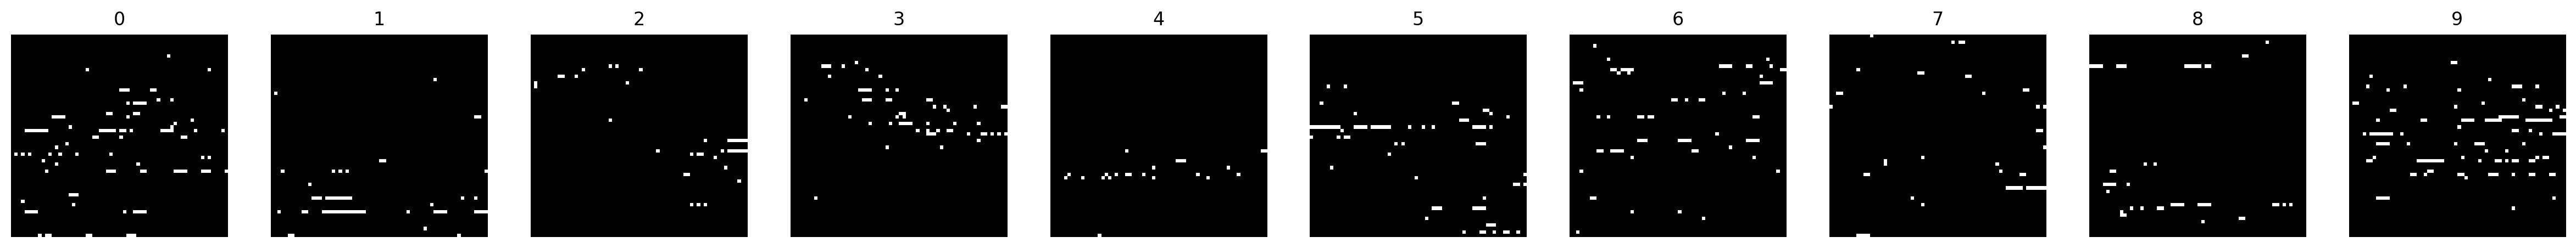

In [ ]:
def generate_labels(num_sample):
    import numpy as np
    from tensorflow.keras.utils import to_categorical

    cond_num = np.zeros((num_sample, 1))
    print("cond_num.shape: ", cond_num.shape)
    for i in range(num_sample):
        ind = i % 4
        print(ind, end=' ')
        cond_num[i] = ind
    print()
    condition_emo = to_categorical(cond_num, 4)
    print("condition_emo.shape: ", condition_emo.shape)
    return condition_emo

import os

def plotRepCVAE(piano_representations, epoch, config, name):
    fig = plt.figure(figsize=(30,20))

    num_samples = piano_representations.shape[0]
    axs = fig.subplots(1, num_samples)

    for i in range(num_samples):
        axs[i].axis('off')
        new_my_pianoroll_rep1 =  np.rot90 (piano_representations[i])

        axs[i].imshow(new_my_pianoroll_rep1, cmap='gray')
        axs[i].set_title(str(i))

    filename1 = 'Samples_%s_images_%04d_%s.png' % (num_samples, epoch+1, name)
    path = os.path.join(MODEL_CONFIG['result_dir'], filename1)

    os.makedirs(MODEL_CONFIG['result_dir'], exist_ok=True)

    print (path)
    plt.savefig(path)
    plt.show()

# ... existing code ...

def run_sampler(vae, epoch, config):
    num_sample = MODEL_CONFIG['num_sample']
    latent_dim = MODEL_CONFIG['latent_dim']
    z_sample = tf.random.normal(shape=(num_sample, latent_dim ))
    # print("z_sample.shape: ", z_sample.shape)

    condition_emo = generate_labels(num_sample)
    print("condition_emo[0]: ", condition_emo[0])
    x_decoded = vae.decoder.predict([z_sample, condition_emo])
    x_decoded_round = x_decoded > 0.7

    # print("x_decoded.shape: ", x_decoded.shape)

    plotRepCVAE(x_decoded_round, epoch, config, name = 'vae_rounded')
    return x_decoded_round

samples = run_sampler(cvae, 500, MODEL_CONFIG)

## Test  back_to_pianoroll

In [ ]:
def back_to_pianoroll(samples):
    print("samples: ", samples.shape)

    samples_piano_representations_arr = np.reshape (samples, (samples.shape[0], samples.shape[1], samples.shape[2] ) )
    samples_p_rep = samples_piano_representations_arr
    samples_pianoroll_rep =  np.pad(samples_p_rep, ( (0, 0), (0, 0), (25, 43)) , 'constant', constant_values=( 0, 0))
    print("samples_pianoroll_rep.shape: ", samples_pianoroll_rep.shape)
    return samples_pianoroll_rep

def save_midi_samples(samples_pianoroll, epoch, config):
    for i in range(samples_pianoroll.shape[0]):
        my_music = muspy.from_pianoroll_representation (samples_pianoroll[i], resolution=4, encode_velocity=False)

#         print(my_music)
        filename1 = 'MIDI_epoch_%04d_%s.mid' % (epoch, i )
        path = os.path.join(config['result_dir'], filename1)
        muspy.write_midi(path , my_music)
        print('MIDI saved to %s' % path)

samples_pianoroll =  back_to_pianoroll(samples)

save_midi_samples(samples_pianoroll, 500, MODEL_CONFIG)

samples:  (10, 64, 60, 1)
samples_pianoroll_rep.shape:  (10, 64, 128)
MIDI saved to ../content/gen/MIDI_epoch_0500_0.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_1.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_2.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_3.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_4.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_5.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_6.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_7.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_8.mid
MIDI saved to ../content/gen/MIDI_epoch_0500_9.mid


train_y_onehot.shape:  (241, 4)
train_y_onehot[0]:  [1. 0. 0. 0.]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


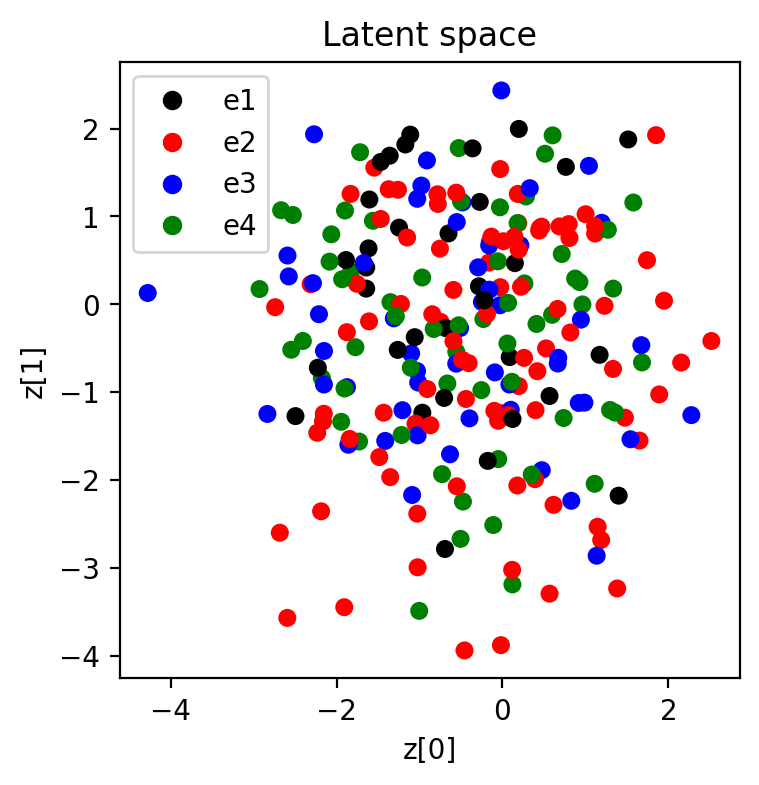

z_mean.shape (241, 32)
0 mean:  -0.42996553 std:  1.2159244
1 mean:  -0.33059946 std:  1.3194864
2 mean:  -0.24023853 std:  0.9803513
3 mean:  -0.05594592 std:  1.194173
4 mean:  0.22257128 std:  1.3210797
5 mean:  0.014386937 std:  1.2199985
6 mean:  0.032601178 std:  0.99751395
7 mean:  -0.13844924 std:  1.2019314
8 mean:  -0.30886808 std:  0.95192206
9 mean:  -0.4142247 std:  0.97807765
10 mean:  0.22907649 std:  1.1719666
11 mean:  -0.13387898 std:  0.92529815
12 mean:  -0.0802366 std:  1.00754
13 mean:  -0.10183012 std:  1.0940351
14 mean:  0.0050646523 std:  1.0013756
15 mean:  0.039586324 std:  1.1494328
16 mean:  0.07240828 std:  0.87168306
17 mean:  -0.24859923 std:  0.8679149
18 mean:  -0.028784597 std:  0.8278153
19 mean:  0.09024808 std:  1.0916351
20 mean:  0.07118224 std:  0.91972506
21 mean:  -0.13806501 std:  1.1569481
22 mean:  0.070612386 std:  1.0664803
23 mean:  -0.116464406 std:  1.0194976
24 mean:  0.27412945 std:  1.1231614
25 mean:  -0.028108252 std:  0.9867166


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_label_clusters(vae, data, y_data_kat, name):
    # display a 2D plot of the digit classes in the latent space
    train_y_onehot =  labels_to_categorical(y_data_kat)

    z_mean, _, _ = vae.encoder.predict([data, train_y_onehot])
    osX = 0
    osY = 1
    plt.figure(figsize=(4, 4))

#     cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
#     emo = {0: 'e1', 1: 'e2', 2: 'e3', 3: 'e4'}

    classes = ['e1', 'e2', 'e3', 'e4']
    colors = ListedColormap(['black', 'red', 'blue', 'green'])
    scatter = plt.scatter(z_mean[:, osX], z_mean[:, osY], c=y_data_kat, cmap=colors, s = 30)
    #add legend with class names

    plt.legend(handles=scatter.legend_elements()[0], labels=classes)

    plt.title("Latent space")
    plt.xlabel ("z["+ str(osX) + "]")
    plt.ylabel ("z["+ str(osY) + "]")
#     ax2.legend()
#     epoch = epoch
    filename1 = 'VAE-subcl_latent_space_cat_%04d_%s.png' % (epoch, name)
    plt.savefig(filename1)
    plt.show()

    print ("z_mean.shape", z_mean.shape)
    for j in range(0, z_mean.shape[1]):
        a = z_mean[:,j]
#         print (a.shape)
        print (j, "mean: ", np.mean(a), "std: ", np.std(a) )

# plot_label_clusters(sigma_vae, X_data_kat, y_data_kat, name = 'sigma_vae' )
X_data_kat = train_X
y_data_kat =  train_y

plot_label_clusters(cvae, X_data_kat, y_data_kat, name = 'vae'  )

## So sánh đầu vào ra đầu ra

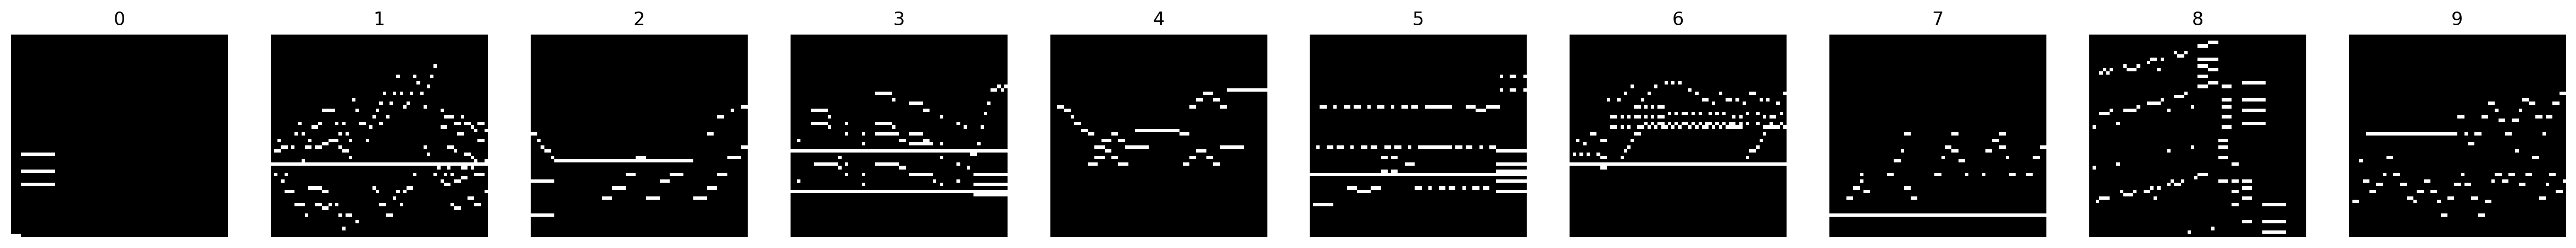

vae_input[0:10].shape :  (10, 64, 60, 1)
train_y[0:10] :  [0 0 3 3 3 2 3 3 0 1]


In [ ]:
num_sample = 10
vae_input = train_X[0:num_sample]
# vae_input = test_X[0:10]

plotMulRep(vae_input, 0 )
print("vae_input[0:10].shape : ", vae_input[0:num_sample].shape ) # vae.predict

print("train_y[0:10] : ", train_y[0:num_sample])

cond_num.shape:  (10, 1)
0 1 2 3 0 1 2 3 0 1 
condition_emo.shape:  (10, 4)
condition_emo[0]:  [1. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
../content/gen/Samples_10_images_1000_vae_rounded.png


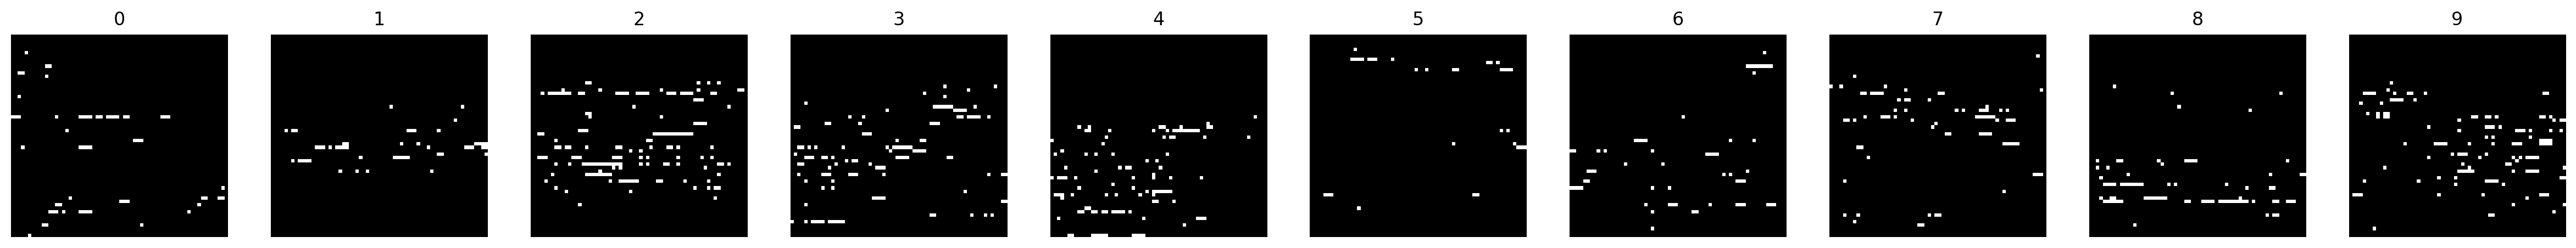

In [ ]:
a = run_sampler(cvae, epoch, MODEL_CONFIG)

In [ ]:
num_sample = MODEL_CONFIG['num_sample']
latent_dim = MODEL_CONFIG['latent_dim']
z_sample = tf.random.normal(shape=(num_sample, latent_dim))
print("z_sample.shape: ", z_sample.shape)

condition_emo = generate_labels(num_sample)

print('condition_emo: ', condition_emo)
print('condition_emo.shape: ', condition_emo.shape)

z_sample.shape:  (10, 32)
cond_num.shape:  (10, 1)
0 1 2 3 0 1 2 3 0 1 
condition_emo.shape:  (10, 4)
condition_emo:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
condition_emo.shape:  (10, 4)


## Generation new Emo seqence

In [ ]:
# Download the Bravura music font if not already downloaded
muspy.download_bravura_font()

# Function to generate sequence x_decoded_round with a given emotion emo={0, 1, 2, 3}
def generate_seq_emo(emo):
    latent_dim = MODEL_CONFIG['latent_dim']
    num_sample = 1
    # Generate chords from randomly generated latent vector
    randomVec = np.random.normal(scale=1, size=(num_sample, latent_dim))
    print('randomVec.shape: ', randomVec.shape)

    cond_num = emo
    condition_emo = to_categorical(cond_num, 4).reshape(1, -1)
    print('condition_emo: ', condition_emo)
    print('condition_emo.shape: ', condition_emo.shape)

    x_decoded = cvae.decoder.predict([randomVec, condition_emo])
    x_decoded_round = x_decoded > 0.5 # Change for more notes
    print('x_decoded_round.shape: ', x_decoded_round.shape)
    return x_decoded_round

# Generate sequence with emotion 1
samples_emo_1 = generate_seq_emo(0)
samples_pianoroll_emo_1 = back_to_pianoroll(samples_emo_1)
my_music_emo_1 = muspy.from_pianoroll_representation(samples_pianoroll_emo_1[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_1.mid', my_music_emo_1)
print("MIDI file saved as 'MIDI_epoch_1000_emo_1.mid'")

# Generate sequence with emotion 2
samples_emo_2 = generate_seq_emo(1)
samples_pianoroll_emo_2 = back_to_pianoroll(samples_emo_2)
my_music_emo_2 = muspy.from_pianoroll_representation(samples_pianoroll_emo_2[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_2.mid', my_music_emo_2)
print("MIDI file saved as 'MIDI_epoch_1000_emo_2.mid'")

# Generate sequence with emotion 3
samples_emo_3 = generate_seq_emo(2)
samples_pianoroll_emo_3 = back_to_pianoroll(samples_emo_3)
my_music_emo_3 = muspy.from_pianoroll_representation(samples_pianoroll_emo_3[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_3.mid', my_music_emo_3)
print("MIDI file saved as 'MIDI_epoch_1000_emo_3.mid'")

# Generate sequence with emotion 4
samples_emo_4 = generate_seq_emo(3)
samples_pianoroll_emo_4 = back_to_pianoroll(samples_emo_4)
my_music_emo_4 = muspy.from_pianoroll_representation(samples_pianoroll_emo_4[0], resolution=4, encode_velocity=False)
muspy.write_midi('../content/data/emo_4.mid', my_music_emo_4)
print("MIDI file saved as 'MIDI_epoch_1000_emo_4.mid'")

Skip downloading as the Bravura font is found.
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
MIDI file saved as 'MIDI_epoch_1000_emo_1.mid'
randomVec.shape:  (1, 32)
condition_emo:  [[0. 1. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
MIDI file saved as 'MIDI_epoch_1000_emo_2.mid'
randomVec.shape:  (1, 32)
condition_emo:  [[0. 0. 1. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
MIDI file saved as 'MIDI_epoch_1000_emo_3.mid'
randomVec.shape:  (1, 32)
condition_emo:  [[0. 0. 0. 1.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

## Tạo nhạc từng cảm xúc và lưu vào file e1-e4

In [ ]:
num = 20
emo = {0: 'e1', 1: 'e2', 2: 'e3', 3: 'e4'}
emo_arr = [0, 1, 2, 3]
gen_dir = '../content/data'

for j in range(len(emo)):
    directory = emo[j]
    path = os.path.join(gen_dir, directory)
    print("path: ", path)
    print("**********************************************************************")

    res = []
    for i in range(num):
        samples = jg_generate_seq_emo(emo_arr[j])
        samples_pianoroll =  back_to_pianoroll(samples)
        my_new_music = muspy.from_pianoroll_representation (samples_pianoroll[0], resolution=4, encode_velocity=False)
#         my_new_music.show_score()
#         my_new_music.show_pianoroll()

        file_name = path + 'new_generated_'+ str(i)+ '.mid'
        muspy.write_midi(file_name, my_new_music)

        if hasattr(res, 'shape'):
            print("Jest shape")
            res = np.concatenate((res, samples_pianoroll), axis=0)
        else:
            print("Brak shape")
            res = samples_pianoroll

    print("res.shape: ", res.shape)



path:  ../content/data/e1
**********************************************************************
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
Brak shape
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
Jest shape
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  (1, 64, 60, 1)
samples_pianoroll_rep.shape:  (1, 64, 128)
Jest shape
randomVec.shape:  (1, 32)
condition_emo:  [[1. 0. 0. 0.]]
condition_emo.shape:  (1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
x_decoded_round.shape:  (1, 64, 60, 1)
samples:  

In [ ]:
!zip -r /content/data.zip /content/data

updating: content/data/ (stored 0%)
updating: content/data/e2new_generated_14.mid (deflated 41%)
updating: content/data/e1new_generated_9.mid (deflated 42%)
updating: content/data/e1new_generated_5.mid (deflated 42%)
updating: content/data/e4new_generated_13.mid (deflated 47%)
updating: content/data/e3new_generated_9.mid (deflated 30%)
updating: content/data/e1new_generated_10.mid (deflated 44%)
updating: content/data/e3new_generated_13.mid (deflated 44%)
updating: content/data/e2new_generated_19.mid (deflated 34%)
updating: content/data/e1new_generated_19.mid (deflated 44%)
updating: content/data/e3new_generated_4.mid (deflated 47%)
updating: content/data/e1new_generated_6.mid (deflated 46%)
updating: content/data/e2new_generated_5.mid (deflated 44%)
updating: content/data/e4new_generated_14.mid (deflated 41%)
updating: content/data/e1new_generated_12.mid (deflated 45%)
updating: content/data/e1new_generated_2.mid (deflated 46%)
updating: content/data/e1new_generated_1.mid (deflated 3